Setup

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.7.0


In [2]:
%pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to c:\users\bhalb\appdata\local\temp\pip-req-build-2ew7a5ki
  Resolved https://github.com/tensorflow/docs to commit 68dc2340900a9fcfe549bae264203a1ee297e78f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Jinja2-3.0.3-py3-none-any.whl (133 kB)
Using legacy 'setup.py install' for tensorflow-docs, since package 'wheel' is not installed.
    Running setup.py install for tensorflow-docs: started
    Running setup.py install for tensorflow-docs: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://github.com/tensorflow/docs 'C:\Users\bhalb\AppData\Local\Temp\pip-req-build-2ew7a5ki'


In [3]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [31]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [32]:
logdir

WindowsPath('C:/Users/bhalb/AppData/Local/Temp/tmp0z8awdds/tensorboard_logs')

In [5]:
gz = tf.keras.utils.get_file(
    'HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 596s 0us/step


In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(
    gz, [float(), ]*(FEATURES+1), compression_type="GZIP")
    

In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


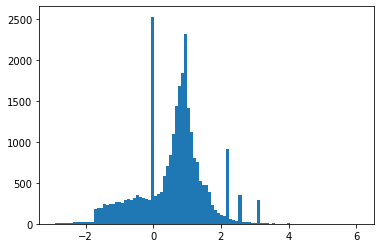

In [9]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)


In [10]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


In [11]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()


In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)


def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


In [15]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(
          monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]


In [16]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'),
                    'accuracy'])

  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0)
  return history


In [17]:
size_histories = {}

Tiny Model

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])


In [20]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4692,  binary_crossentropy:0.8016,  loss:0.8016,  val_accuracy:0.4620,  val_binary_crossentropy:0.7769,  val_loss:0.7769,  
....................................................................................................
Epoch: 100, accuracy:0.5910,  binary_crossentropy:0.6285,  loss:0.6285,  val_accuracy:0.5760,  val_binary_crossentropy:0.6316,  val_loss:0.6316,  
............................................................

(0.5, 0.7)

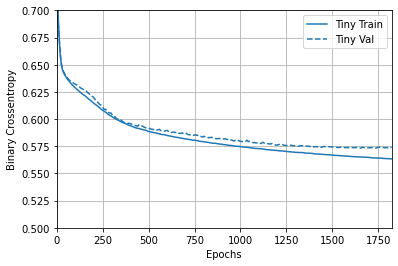

In [21]:
plotter = tfdocs.plots.HistoryPlotter(
    metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])


Small Model

In [22]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])


In [23]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4759,  binary_crossentropy:0.7473,  loss:0.7473,  val_accuracy:0.4680,  val_binary_crossentropy:0.7064,  val_loss:0.7064,  
....................................................................................................
Epoch: 100, accuracy:0.6011,  binary_crossentropy:0.6261,  loss:0.6261,  

(0.5, 0.7)

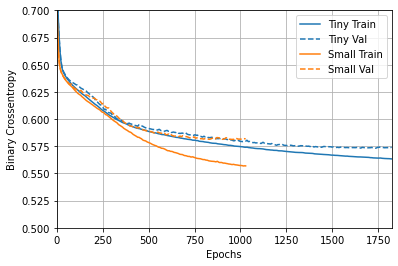

In [24]:
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])


Medium Model

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5199,  binary_crossentropy:0.6811,  loss:0.6811,  val_accuracy:0.5320,  val_binary_crossentropy:0.6674,  val_loss:0.6674,  
....................................

In [27]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4957,  binary_crossentropy

Text(0.5, 0, 'Epochs [Log Scale]')

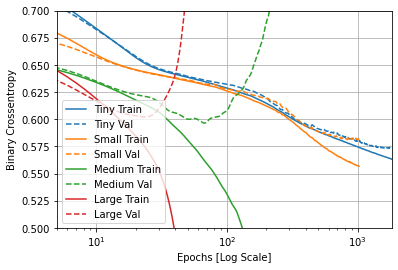

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

View in TensorBoard
run: tensorboard --logdir {logdir}

In [66]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/bhalb/AppData/Local/Temp/tmpu4ftdbui/tensorboard_logs/regularizers/Tiny')

In [67]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [68]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5117,  binary_crossentropy

(0.5, 0.7)

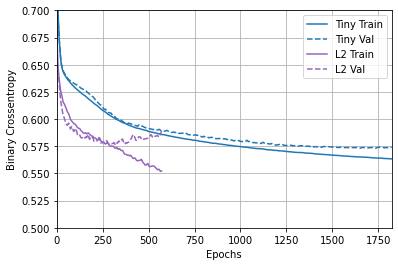

In [69]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])


In [72]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(
    dropout_model, "regularizers/dropout")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

In [73]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(
    combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

(0.5, 0.7)

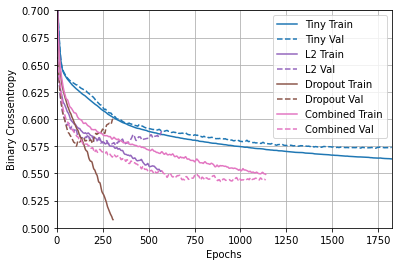

In [74]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])